<a href="https://colab.research.google.com/github/GermanOmar/AlejandraAlban/blob/master/A36_GS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRAIN SIZE MEASUREMENT

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2 
from scipy import ndimage
from skimage import measure, color, io
from google.colab.patches import cv2_imshow # for image display

In [ ]:
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage

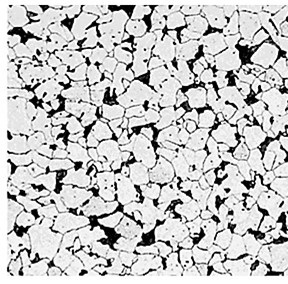

In [ ]:
#url="https://i.ibb.co/ngQcMMp/example.jpg"  #WORKS PERFECT
url="https://i.ibb.co/Vw3B4Dt/F5.jpg"

image = io.imread(url)
#image = cv2.bitwise_not(image)
#shifted = cv2.pyrMeanShiftFiltering(image, 1, 51)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

cv2_imshow(gray)

(array([ 2801.,  1195.,   605.,   641.,   303.,   431.,   250.,   281.,
          184.,   265.,   227.,   160.,   228.,   139.,   219.,   132.,
          204.,   145.,   204.,   122.,   200.,   176.,   100.,   177.,
          111.,   184.,   105.,   172.,   113.,   181.,   183.,   127.,
          169.,   141.,   177.,   122.,   195.,   126.,   171.,   123.,
          178.,   201.,   128.,   196.,   137.,   198.,   137.,   193.,
          134.,   212.,   236.,   165.,   254.,   171.,   240.,   154.,
          221.,   150.,   276.,   189.,   289.,   304.,   200.,   287.,
          197.,   308.,   199.,   321.,   210.,   326.,   319.,   244.,
          366.,   278.,   405.,   319.,   444.,   290.,   454.,   334.,
          514.,   658.,   445.,   724.,   606.,  1101.,  1021.,  2233.,
         2322.,  5074.,  5212.,  3323.,  4635.,  3071.,  4467.,  2901.,
         3830.,  2576.,  4396., 11030.]),
 array([  0.  ,   2.55,   5.1 ,   7.65,  10.2 ,  12.75,  15.3 ,  17.85,
         20.4 ,  22.95

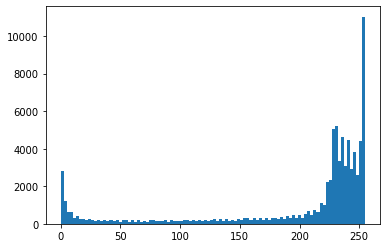

In [ ]:
#Non local means filter
plt.hist(gray.flat, bins=100, range=(0,255))

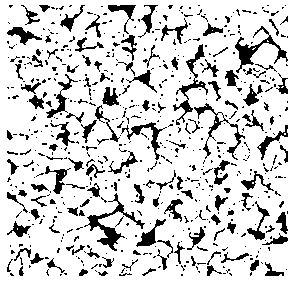

In [ ]:
thresh = cv2.threshold(gray, 0, 255, 	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

cv2_imshow(thresh)

Erosion

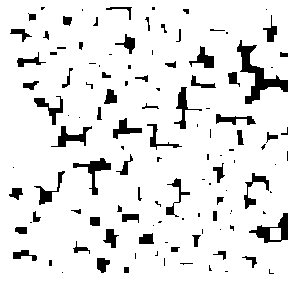

In [ ]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 3)

from skimage.segmentation import clear_border
#opening = clear_border(opening) #Remove edge touching grains
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=2)

cv2_imshow(sure_bg)

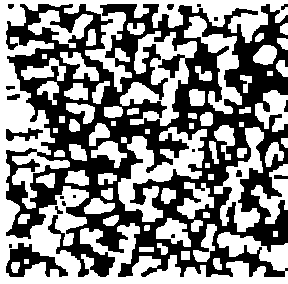

In [ ]:
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,3)
ret, sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)

sure_fg = np.uint8(sure_fg)
cv2_imshow(sure_fg)

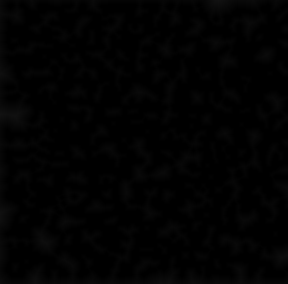

In [ ]:
cv2_imshow(dist_transform)

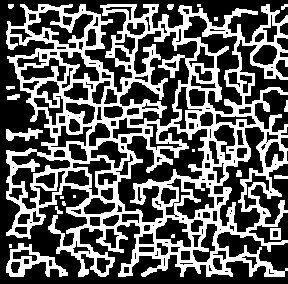

In [ ]:
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

cv2_imshow(unknown)

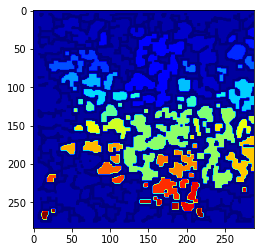

In [ ]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+2

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
plt.imshow(markers, cmap='jet')
#cv2_imshow(markers)


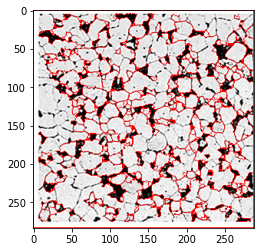

In [ ]:
markers = cv2.watershed(image,markers)
image[markers == -1] = [255,0,0]
plt.imshow(image) 

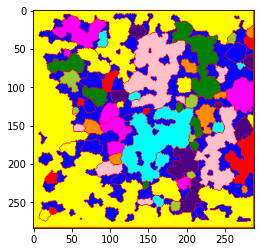

In [ ]:
img2 = color.label2rgb(markers, bg_label=0)
plt.imshow(img2)


Results:

In [ ]:
pixels_to_um = 1.06 # 1 pixel = 1000 nm (95 pixel = 100 um)

regions = measure.regionprops(markers, intensity_image=gray)

#Can print various parameters for all objects
#for prop in regions:
#    print('Label: {} Area: {}'.format(prop.label, prop.area))

#Best way is to output all properties to a csv file
#Let us pick which ones we want to export. 

propList = ['Area',
            'equivalent_diameter', #Added... verify if it works
            'orientation', #Added, verify if it works. Angle btwn x-axis and major axis.
            'MajorAxisLength',
            'MinorAxisLength',
            'Perimeter']    
    

output_file = open('ASTM-GS.csv', 'w')
output_file.write('Grain_N' + "," + "," + ",".join(propList) + '\n') #join strings in array by commas, 
#First cell to print grain number
#Second cell blank as we will not print Label column

grain_number = 1
for region_props in regions:
    output_file.write(str(grain_number) + ',')
    #output cluster properties to the excel file
#    output_file.write(str(region_props['Label']))
    for i,prop in enumerate(propList):
        if(prop == 'Area'): 
            to_print = region_props[prop]*pixels_to_um**2   #Convert pixel square to um square
        elif(prop == 'orientation'): 
            to_print = region_props[prop]*57.2958  #Convert to degrees from radians
        elif(prop.find('Intensity') < 0):          # Any prop without Intensity in its name
            to_print = region_props[prop]*pixels_to_um
        else: 
            to_print = region_props[prop]     #Reamining props, basically the ones with Intensity in its name
        output_file.write(',' + str(to_print))
    output_file.write('\n')
    grain_number += 1
    
output_file.close()   #Closes the file, otherwise it would be read only. 

In [ ]:
for prop in regions:
  print('Label: {} Diameter: {} '.format(prop.label, prop.equivalent_diameter))

Label: 2 Diameter: 138.689688882462 
Label: 3 Diameter: 180.03925219203666 
Label: 4 Diameter: 41.42857596276994 
Label: 5 Diameter: 56.72280255369754 
Label: 6 Diameter: 18.643883600599406 
Label: 7 Diameter: 11.340070282773887 
Label: 8 Diameter: 16.545286401814263 
Label: 9 Diameter: 73.44873008461674 
Label: 10 Diameter: 11.834540545406394 
Label: 11 Diameter: 12.964089628857149 
Label: 12 Diameter: 24.201036973199617 
Label: 13 Diameter: 30.90193616185517 
Label: 14 Diameter: 8.444016491289505 
Label: 15 Diameter: 30.943111311580196 
Label: 16 Diameter: 15.430353037616328 
Label: 17 Diameter: 17.14987856615383 
Label: 18 Diameter: 8.884866446580956 
Label: 19 Diameter: 16.39065416446578 
Label: 20 Diameter: 23.58825303088947 
Label: 21 Diameter: 19.867165345562018 
Label: 22 Diameter: 22.93137440223813 
Label: 23 Diameter: 19.899183360445615 
Label: 24 Diameter: 38.24855862513909 
Label: 25 Diameter: 25.507359866510456 
Label: 26 Diameter: 18.712051592547777 
Label: 27 Diameter: 1

In [ ]:
GS=np.mean(np.array(prop.equivalent_diameter))
print(" grain size = ", GS)

AttributeError: ignored